In [1]:
%pylab inline
import time 
import random
import pickle
import os
import sys
from pathlib import Path
sys.path.append("../src")

from IPython.display import Audio
from tqdm import tqdm, trange
import pandas as pd
import torch 
import miniaudio

%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%aimport -auto

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA_DIR = "/home/keld/projects/music_gen/sc_scrape/data/"

archive_tracker_path = "/d16Tb/soundcloud_music/archive_tracker"
out_path = "/d16Tb/soundcloud_music/files/"    

data_obj_path = f"{DATA_DIR}sc_data_v2.pckl"

In [3]:
os.listdir(DATA_DIR)

['.gitkeep',
 'music_info.tsv.gz',
 'archive_tracker',
 'sc_data_v2.pckl',
 'chromedriver']

In [4]:
all_music_info_df = pd.read_csv(f"{DATA_DIR}music_info.tsv.gz", compression='gzip', sep='\t')

/tmp/ipykernel_57093/1836521378.py:1: DtypeWarning: Columns (1,6,21) have mixed types. Specify dtype option on import or set low_memory=False.
  all_music_info_df = pd.read_csv(f"{DATA_DIR}music_info.tsv.gz", compression='gzip', sep='\t')


In [8]:
! ls /n1Tb

MonkeyIsland_intro.mp3	    sc_mp3_classical
OVERWERK_-_Create.mp3	    sc_mp3_top50_genre_samples
radiohead_hacked_md111.mp3  sc_mp3_top50_genre_samples.tsv_gz
reencoding		    tmp
sc_download_files


In [9]:
top50_genre_samples_df = pd.read_csv("/n1Tb/sc_mp3_top50_genre_samples.tsv_gz", compression='gzip', sep='\t')

In [10]:
fp = top50_genre_samples_df.nvme_fp.values[0]

### Load song segment

In [11]:
from miniaudio import SeekOrigin, mp3_read_s16


class FileSource(miniaudio.StreamableSource):
    def __init__(self, fp: str) -> None:
        # filename = os.path.join(os.path.abspath(os.path.dirname(__file__)), 'samples', filename)
        self.file = open(fp, "rb")

    def read(self, num_bytes: int) -> bytes:
        print("reading from stream:", num_bytes)
        return self.file.read(num_bytes)

    def seek(self, offset: int, origin: SeekOrigin) -> bool:
        # note: seek support is usually not needed if you provide the file format to the decoder upfront
        # this is necessary if dealing with a network stream for instance
        whence = 0
        if origin == SeekOrigin.START:
            whence = 0
        elif origin == SeekOrigin.CURRENT:
            whence = 1
        self.file.seek(offset, whence)
        return True

    def close(self) -> None:
        self.file.close()

# with FileSource(fp) as source:
#     source.seek(100000, 0)
#     data = mp3_read_s16(source.read(100000))


reading from stream: 100000


In [13]:
# %%timeit -n 1 -r 1
with FileSource(fp) as source:
    source.seek(100000, 0)
    data = mp3_read_s16(source.read(100000))

reading from stream: 100000


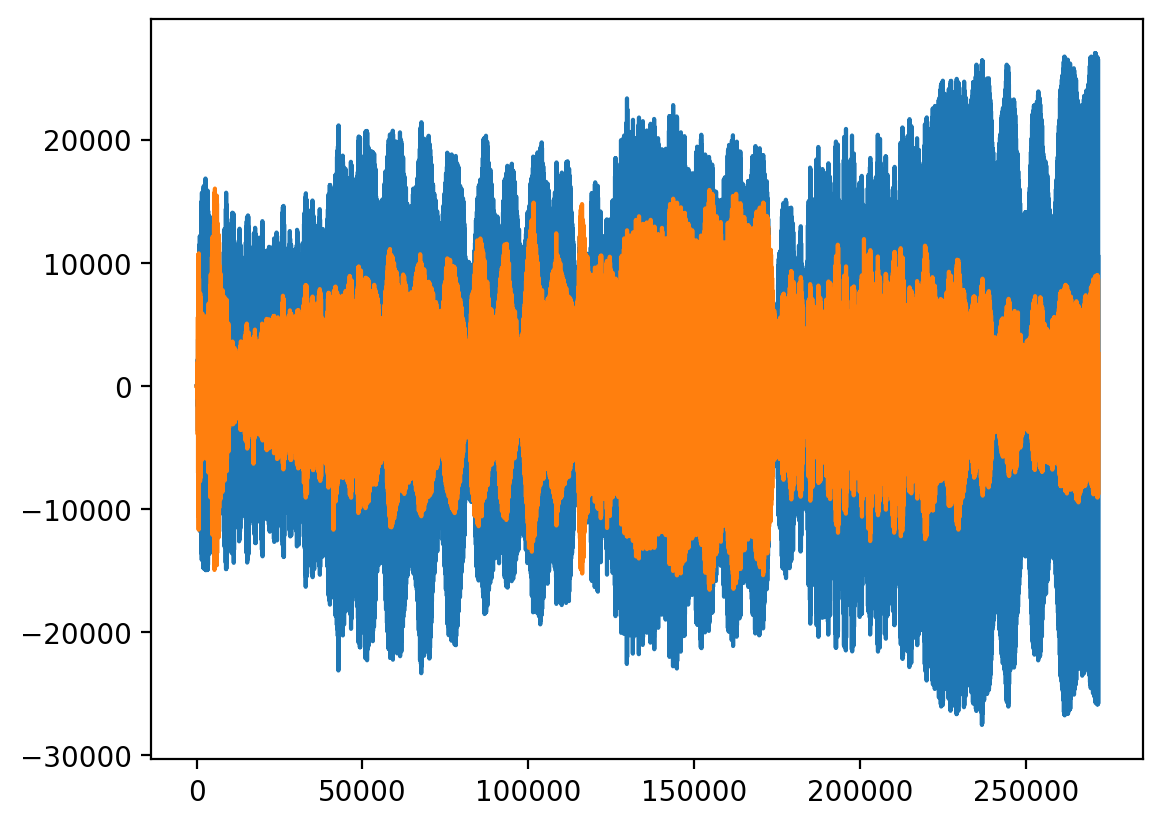

In [16]:
npa = numpy.array(data.samples, dtype=numpy.int16).reshape((-1, data.nchannels))
plt.plot(npa);

In [17]:
Audio([npa[:, 0], npa[:, 1]],rate=data.sample_rate)

In [14]:
npa = numpy.array(data.samples, dtype=numpy.int16).reshape((-1, decoded.nchannels))
plt.plot(npa);

NameError: name 'decoded' is not defined

### decode music

In [25]:
decoded = miniaudio.decode_file(fp)


In [28]:
decoded

<DecodedSoundFile: '/n1Tb/sc_mp3_top50_genre_samples/Mood Cake (chilled)_071_Dawn.mp3' 2 ch, 44100 hz, SIGNED16, 8570880 frames=194.35 sec.>

In [29]:
npa = numpy.array(decoded.samples, dtype=numpy.int16).reshape((-1, decoded.nchannels))

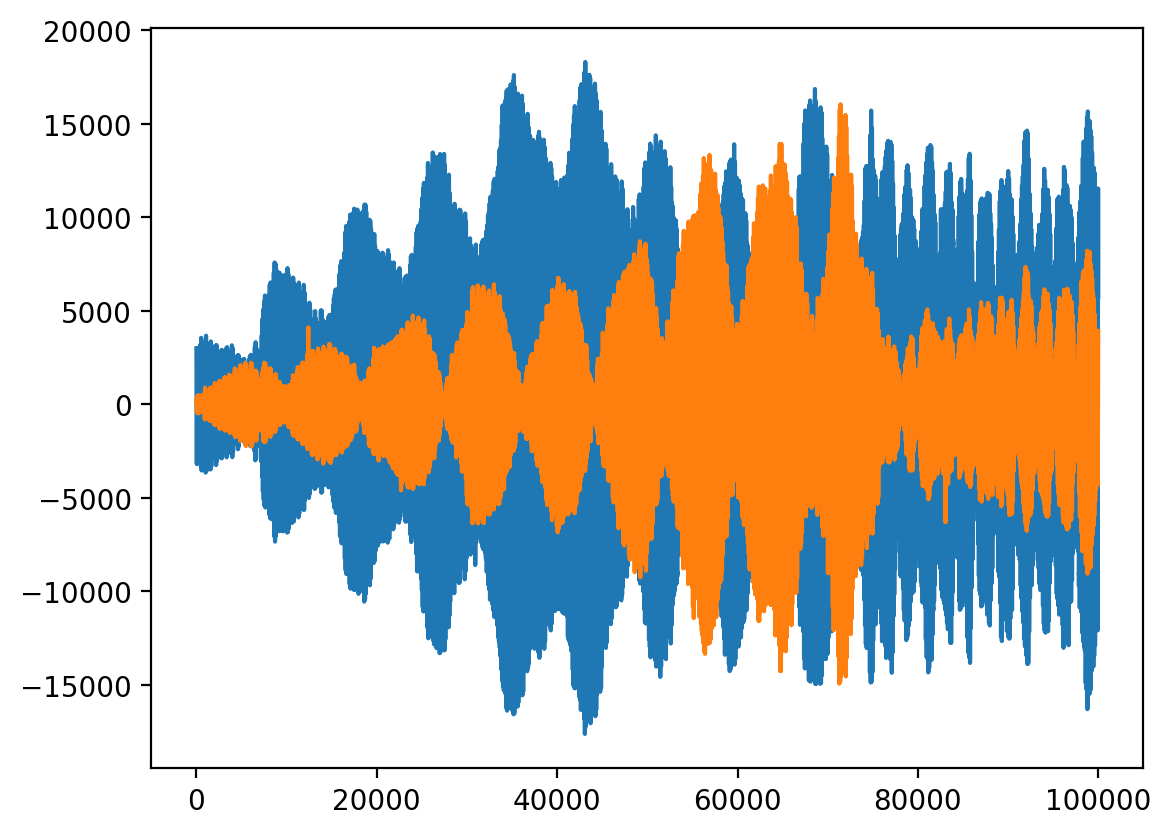

In [37]:
plt.plot(npa[100000:200000]);

In [38]:
%%timeit -r 1 -n 1
decoded = miniaudio.decode_file(fp)

177 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### play audio

In [73]:
from miniaudio import mp3_read_s16


fp = top50_genre_samples_df.nvme_fp.values[101]

with open(fp, "rb") as f:
    f.seek(100000, 0)
    decoded = mp3_read_s16(f.read(100000))

npa = numpy.array(decoded.samples, dtype=numpy.int16).reshape((-1, decoded.nchannels))

Audio([npa[:, 0], npa[:, 1]],rate=decoded.sample_rate)

In [ ]:
decoded

### Function for opening

In [18]:
from miniaudio import mp3_read_s16

class Mp3Stream:
    
    def __init__(self, fp):
        self.fp = fp
        self.decoded = None
        self.rate = None
        
    def np_decode(self, n_size, offset):
        decoded = self.decode(n_size, offset)
        return np.array(decoded.samples, dtype=numpy.int16).reshape((-1, decoded.nchannels))
        
    def decode(self, n_size, offset):
        with open(self.fp, "rb") as f:
            f.seek(offset, 0)
            decoded = mp3_read_s16(f.read(n_size))
        self.decoded = decoded
        self.sample_rate = decoded.sample_rate
        return decoded

    def play(self, n_size=-1, offset=0, autoplay=False):
        npa = self.np_decode(n_size, offset)
        return Audio([npa[:, 0], npa[:, 1]],rate=self.sample_rate, autoplay=autoplay)

In [19]:
fp = top50_genre_samples_df.nvme_fp.values[10012]
Mp3Stream(fp).play(200000, int(1e5), 1)

#### Using  